# 03_feature_engineering - Simple Feature Creation

This notebook applies simple feature engineering: log-transform of amount, extract hour/weekday from timestamps (if present), and compute simple per-account aggregates (total incoming/outgoing, counts). Each operation is placed in its own cell for clarity.

In [29]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..','src')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engineering import apply_feature_engineering

RAW = os.path.abspath(os.path.join('..','data','raw'))
PROCESSED = os.path.abspath(os.path.join('..','data','processed'))

csvs = [f for f in os.listdir(PROCESSED) if f.lower().endswith('.csv')] if os.path.exists(PROCESSED) else []
print('Processed CSVs found:', csvs)


Processed CSVs found: ['cleaned.csv', 'features.csv', 'features_pca.csv']


In [30]:
# Load cleaned data if available, otherwise load first raw CSV
cleaned_path = os.path.join(PROCESSED, 'cleaned.csv')
if os.path.exists(cleaned_path):
    df = pd.read_csv(cleaned_path)
    print('Loaded cleaned:', cleaned_path)
else:
    raw_csvs = [f for f in os.listdir(RAW) if f.lower().endswith('.csv')] if os.path.exists(RAW) else []
    if not raw_csvs:
        print('No CSVs found in data/raw. Please add dataset.')
    else:
        df = pd.read_csv(os.path.join(RAW, raw_csvs[0]))
        print('Loaded raw:', raw_csvs[0])


Loaded cleaned: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\cleaned.csv
 c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\cleaned.csv


In [31]:
# Show first rows
try:
    display(df.head())
except NameError:
    print('No dataframe loaded.')


,Time,Date,Sender_account,Receiver_account,Amount,Is_laundering,timestamp,Payment_currency_Albanian lek,Payment_currency_Dirham,Payment_currency_Euro,...,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_ACH,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card
0,12574,20,4748378277,4597607403,10930.18,0,2022-10-27 11:05:46,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,35004,214,961567601,3014640762,1438.37,0,2023-05-09 21:31:31,False,False,False,...,False,True,False,False,False,False,False,False,False,True
2,14596,141,1389985052,4062285920,4947.02,0,2023-02-25 12:01:02,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,22840,3,8600542721,5111509251,878.24,1,2022-10-10 15:48:22,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,16813,247,1179006073,9411930184,8786.58,0,2023-06-11 13:02:27,False,False,False,...,False,True,False,False,False,False,False,True,False,False


In [32]:
# Apply feature engineering and save features
from feature_engineering import apply_feature_engineering, save_features

print('Before shape:', df.shape)
features = apply_feature_engineering(df, save_path=os.path.join(PROCESSED,'features.csv'))
print('After shape:', features.shape)


Before shape: (59238, 76)
After shape: (59238, 84)
After shape: (59238, 84)


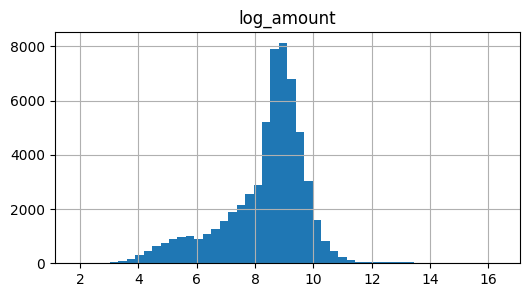

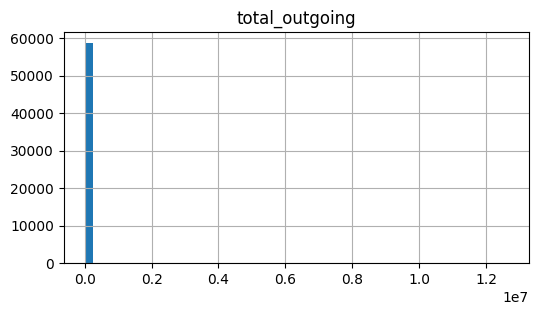

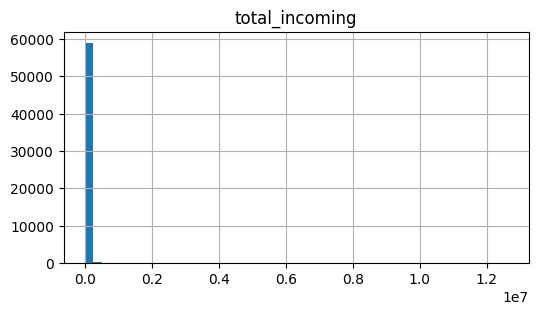

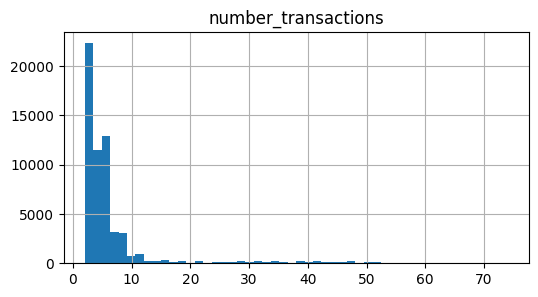

In [33]:
# Histograms of new features: log_amount, total_outgoing, total_incoming, number_transactions
import matplotlib.pyplot as plt

if 'log_amount' in features.columns:
    plt.figure(figsize=(6,3))
    features['log_amount'].hist(bins=50)
    plt.title('log_amount')
    plt.show()

for col in ['total_outgoing','total_incoming','number_transactions']:
    if col in features.columns:
        plt.figure(figsize=(6,3))
        features[col].hist(bins=50)
        plt.title(col)
        plt.show()


# Dimensionality Reduction with PCA

Apply Principal Component Analysis (PCA) to reduce the dimensionality of the feature space while retaining most of the variance. This helps with:
- Removing multicollinearity
- Reducing overfitting
- Improving model training speed
- Capturing the most important patterns in the data

In [34]:
# Prepare data for PCA: select only numeric features and standardize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric features only (exclude target and ID columns)
exclude_cols = ['Is_laundering', 'Laundering_type', 'id', 'transaction_id', 'account_id', 'customer_id']
numeric_features = features.select_dtypes(include=[np.number])
numeric_features = numeric_features.drop(columns=[col for col in exclude_cols if col in numeric_features.columns], errors='ignore')

print(f'Number of numeric features before PCA: {numeric_features.shape[1]}')
print(f'Features: {list(numeric_features.columns)}')

Number of numeric features before PCA: 13
Features: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'log_amount', 'hour', 'weekday', 'total_outgoing', 'num_outgoing', 'total_incoming', 'num_incoming', 'number_transactions']


In [35]:
# Standardize the features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

print(f'Scaled data shape: {X_scaled.shape}')
print(f'Mean after scaling: {X_scaled.mean(axis=0)[:3]} (should be ~0)')
print(f'Std after scaling: {X_scaled.std(axis=0)[:3]} (should be ~1)')

Scaled data shape: (59238, 13)
Mean after scaling: [-7.17283764e-17  7.96448861e-17  1.07772485e-16] (should be ~0)
Std after scaling: [1. 1. 1.] (should be ~1)


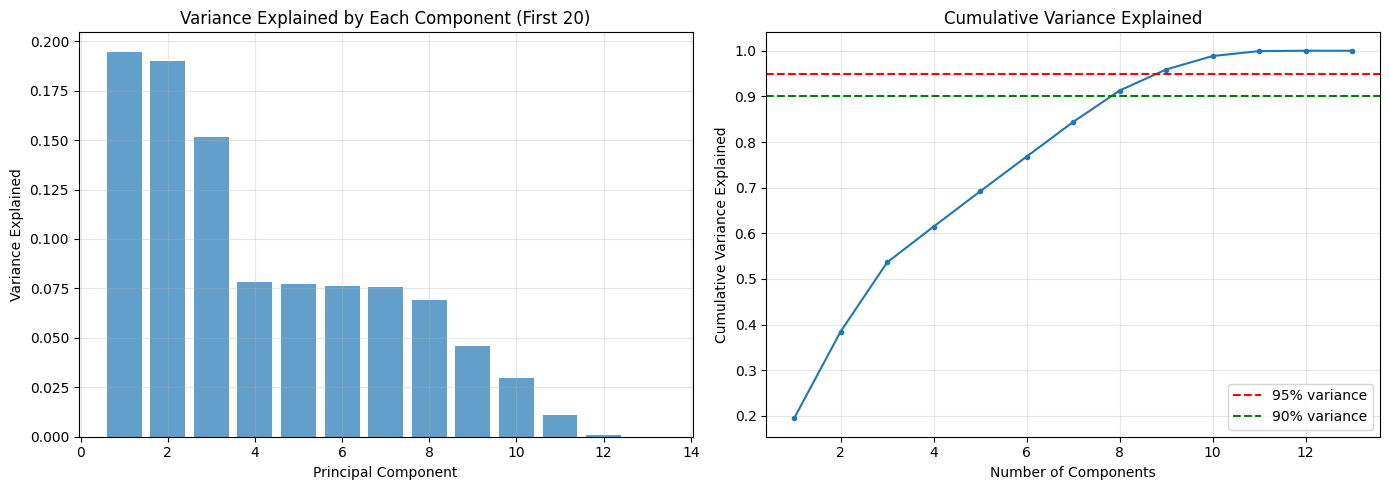


Number of components for 90% variance: 8 (from 13)
Number of components for 95% variance: 9 (from 13)
Dimensionality reduction: 13 → 9 features


In [36]:
# Analyze variance explained by each principal component
# First, fit PCA with all components to see cumulative variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_[:20], alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance Explained by Each Component (First 20)')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', markersize=3)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f'\nNumber of components for 90% variance: {n_components_90} (from {len(pca_full.components_)})')
print(f'Number of components for 95% variance: {n_components_95} (from {len(pca_full.components_)})')
print(f'Dimensionality reduction: {len(pca_full.components_)} → {n_components_95} features')

In [37]:
# Apply PCA with optimal number of components (95% variance)
pca_optimal = PCA(n_components=n_components_95)
X_pca = pca_optimal.fit_transform(X_scaled)

print(f'Original feature space: {X_scaled.shape[1]} dimensions')
print(f'PCA feature space: {X_pca.shape[1]} dimensions')
print(f'Variance retained: {pca_optimal.explained_variance_ratio_.sum():.4f}')

# Create PCA feature dataframe
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=features.index)

# Add back the target variable and important ID columns
for col in ['Is_laundering', 'Laundering_type']:
    if col in features.columns:
        df_pca[col] = features[col].values

print(f'\nPCA features shape: {df_pca.shape}')
display(df_pca.head())

Original feature space: 13 dimensions
PCA feature space: 9 dimensions
Variance retained: 0.9588

PCA features shape: (59238, 10)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Is_laundering
0,-0.031464,-0.006169,-0.917126,-0.814123,0.284769,-0.970423,-0.792490,0.446173,0.642989,0
1,-0.311863,-0.616561,1.608432,1.799109,0.391004,-0.233554,-0.596044,-0.847150,-0.133620,0
2,-0.261352,-0.300483,-0.740346,0.008188,0.291821,0.753601,-1.432404,-0.074647,0.192772,0
3,0.837002,0.163706,0.338912,-0.789262,0.063868,-2.423567,0.651611,-1.093223,0.517867,1
4,-0.475517,-0.301857,-0.497396,-0.182562,1.326896,2.311744,-0.212501,0.227423,0.353104,0


In [38]:
# Analyze the most important original features for each principal component
n_top_features = 5  # Show top 5 features per component

print(f'Top {n_top_features} features contributing to each principal component:\n')

for i in range(min(5, len(pca_optimal.components_))):  # Show first 5 PCs
    pc = pca_optimal.components_[i]
    top_indices = np.argsort(np.abs(pc))[-n_top_features:][::-1]
    
    print(f'PC{i+1} (explains {pca_optimal.explained_variance_ratio_[i]:.2%} variance):')
    for idx in top_indices:
        feature_name = numeric_features.columns[idx]
        weight = pc[idx]
        print(f'  {feature_name:30s}: {weight:+.4f}')
    print()

Top 5 features contributing to each principal component:

PC1 (explains 19.47% variance):
  number_transactions           : +0.4947
  num_incoming                  : +0.4193
  num_outgoing                  : +0.4176
  Amount                        : -0.3437
  log_amount                    : -0.2988

PC2 (explains 19.01% variance):
  total_incoming                : +0.4925
  Amount                        : +0.4857
  total_outgoing                : +0.4422
  number_transactions           : +0.3610
  num_incoming                  : +0.3236

PC3 (explains 15.15% variance):
  hour                          : +0.6927
  Time                          : +0.6925
  number_transactions           : +0.1294
  num_incoming                  : +0.1221
  num_outgoing                  : +0.0904

PC4 (explains 7.84% variance):
  Date                          : +0.5873
  weekday                       : -0.5646
  Sender_account                : -0.4725
  Receiver_account              : -0.3356
  num_outgoing

In [39]:
# Save PCA-transformed features
import numpy as np

pca_features_path = os.path.join(PROCESSED, 'features_pca.csv')
df_pca.to_csv(pca_features_path, index=False)
print(f'PCA features saved to: {pca_features_path}')

# Also save the scaler and PCA model for future use
import joblib
scaler_path = os.path.join(PROCESSED, 'scaler.pkl')
pca_path = os.path.join(PROCESSED, 'pca_model.pkl')

joblib.dump(scaler, scaler_path)
joblib.dump(pca_optimal, pca_path)

print(f'Scaler saved to: {scaler_path}')
print(f'PCA model saved to: {pca_path}')
print(f'\nNote: Use features_pca.csv for modeling to benefit from dimensionality reduction')

PCA features saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\features_pca.csv
Scaler saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\scaler.pkl
PCA model saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\processed\pca_model.pkl

Note: Use features_pca.csv for modeling to benefit from dimensionality reduction
